In [1]:
import csv
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shapefile as shp
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
import sup_func as sfu
import geograph_code as geo
import geopandas as gpd
import geocode as gc
%matplotlib inline

#I get the df from website worldometers.info

url_popu = 'https://www.worldometers.info/world-population/population-by-country/'
url_covid = 'https://www.worldometers.info/coronavirus/#countries'
r_popu = requests.get(url_popu)
r_covid = requests.get(url_covid)
soup_popu = BeautifulSoup(r_popu.content)
soup_covid = BeautifulSoup(r_covid.content)
countries_popu = soup_popu.find_all('table')[0]
countries_covid = soup_covid.find_all('table')[0]
df_popu = pd.read_html(str(countries_popu))[0]
df_covid = pd.read_html(str(countries_covid))[0]
df_popu.head()

,#,Country (or dependency),Population (2020),Yearly Change,Net Change,Density (P/Km²),Land Area (Km²),Migrants (net),Fert. Rate,Med. Age,Urban Pop %,World Share
0,1,China,1439323776,0.39 %,5540090,153,9388211,-348399.0,1.7,38,61 %,18.47 %
1,2,India,1380004385,0.99 %,13586631,464,2973190,-532687.0,2.2,28,35 %,17.70 %
2,3,United States,331002651,0.59 %,1937734,36,9147420,954806.0,1.8,38,83 %,4.25 %
3,4,Indonesia,273523615,1.07 %,2898047,151,1811570,-98955.0,2.3,30,56 %,3.51 %
4,5,Pakistan,220892340,2.00 %,4327022,287,770880,-233379.0,3.6,23,35 %,2.83 %


In [2]:
df_covid.head()

,"Country,Other",TotalCases,NewCases,TotalDeaths,NewDeaths,TotalRecovered,ActiveCases,"Serious,Critical",Tot Cases/1M pop,Deaths/1M pop,TotalTests,Tests/ 1M pop
0,World,3118871,"+56,356",216281.0,"+4,832",947190.0,1955400,56381.0,400.0,27.7,NaN,NaN
1,USA,1027024,"+16,668",58341.0,"+1,544",140138.0,828545,14489.0,3103.0,176.0,5811207.0,17556.0
2,Spain,232128,"+2,706",23822.0,+301,123903.0,84403,7764.0,4965.0,510.0,1345560.0,28779.0
3,Italy,201505,"+2,091",27359.0,+382,68941.0,105205,1863.0,3333.0,453.0,1846934.0,30547.0
4,France,165842,NaN,23660.0,+367,45513.0,96669,4608.0,2541.0,362.0,463662.0,7103.0


In [3]:
#I get the columns that I want to use from df_popu

df_raw = pd.DataFrame({'A' : []})
df_raw['Country (or dependency)'] = df_popu['Country (or dependency)']
df_raw['Population (2020)'] = df_popu['Population (2020)']
df_raw['Density (P/Km²)'] = df_popu['Density (P/Km²)']
df_raw['Land Area (Km²)'] = df_popu['Land Area (Km²)']
df_raw['Migrants (net)'] = df_popu['Migrants (net)']
df_raw['Med. Age'] = df_popu['Med. Age']
df_raw['Urban Pop %'] = df_popu['Urban Pop %']
df_raw = df_raw.dropna(how='all',axis=1)
df_raw.head()

,Country (or dependency),Population (2020),Density (P/Km²),Land Area (Km²),Migrants (net),Med. Age,Urban Pop %
0,China,1439323776,153,9388211,-348399.0,38,61 %
1,India,1380004385,464,2973190,-532687.0,28,35 %
2,United States,331002651,36,9147420,954806.0,38,83 %
3,Indonesia,273523615,151,1811570,-98955.0,30,56 %
4,Pakistan,220892340,287,770880,-233379.0,23,35 %


In [4]:

#After checking both countries columns, I try match both columns with below dictionary
country_dic = {'USA':'United States', 'UK':'United Kingdom', 'S. Korea':'South Korea', 'UAE':'United Arab Emirates',
               'Czechia':'Czech Republic (Czechia)', 'Ivory Coast':"Côte d'Ivoire", 'DRC':'DR Congo',
               'Palestine':'State of Palestine', 'CAR':'Central African Republic', 'Saint Kitts and Nevis':'Saint Kitts & Nevis',
               'St. Vincent Grenadines':'St. Vincent & Grenadines', 'Vatican City':'Holy See', 'St. Barth':'Saint Barthelemy',
               'Sao Tome and Principe':'Sao Tome & Principe', 'Saint Pierre Miquelon':'Saint Pierre & Miquelon'}
df_covid['Country (or dependency)'] = df_covid['Country,Other']
df_covid.replace({'Country (or dependency)': country_dic},  inplace = True)
#I remove the columns from df_covid that I am not interested in 
df_subs = df_covid.drop([df_covid.columns[8],'Country,Other','NewCases','NewDeaths','ActiveCases','Serious,Critical','Tests/ 1M pop','Deaths/1M pop'],axis=1)
df_subs.head()

,TotalCases,TotalDeaths,TotalRecovered,TotalTests,Country (or dependency)
0,3118871,216281.0,947190.0,NaN,World
1,1027024,58341.0,140138.0,5811207.0,United States
2,232128,23822.0,123903.0,1345560.0,Spain
3,201505,27359.0,68941.0,1846934.0,Italy
4,165842,23660.0,45513.0,463662.0,France


In [5]:
#I join both tables using as index the country
df_raw = df_raw.join(df_subs.set_index('Country (or dependency)'), on='Country (or dependency)')
df_raw.head()

,Country (or dependency),Population (2020),Density (P/Km²),Land Area (Km²),Migrants (net),Med. Age,Urban Pop %,TotalCases,TotalDeaths,TotalRecovered,TotalTests
0,China,1439323776,153,9388211,-348399.0,38,61 %,82836.0,4633.0,77555.0,NaN
1,India,1380004385,464,2973190,-532687.0,28,35 %,31360.0,1008.0,7747.0,716733.0
2,United States,331002651,36,9147420,954806.0,38,83 %,1027024.0,58341.0,140138.0,5811207.0
3,Indonesia,273523615,151,1811570,-98955.0,30,56 %,9511.0,773.0,1254.0,79618.0
4,Pakistan,220892340,287,770880,-233379.0,23,35 %,14612.0,312.0,3233.0,157223.0


In [6]:
#I have called dtypes to check where I have non-numeric columns to change its type.
df_raw.dtypes

Country (or dependency)     object
Population (2020)            int64
Density (P/Km²)              int64
Land Area (Km²)              int64
Migrants (net)             float64
Med. Age                    object
Urban Pop %                 object
TotalCases                 float64
TotalDeaths                float64
TotalRecovered             float64
TotalTests                 float64
dtype: object

In [7]:
#lets start for Urban POP, I change % values to floats, 100% is 1 0% is 0
indexes = df_raw.index.values.tolist()
for index in indexes:
    per = df_raw.loc[index,'Urban Pop %']
    if per == 'N.A.':
        df_raw.loc[index,'Urban Pop %'] = np.nan
    else:
        if type(per) is str:
            if per == '0 %':
                df_raw.loc[index,'Urban Pop %'] = 0
            else:
                df_raw.loc[index,'Urban Pop %'] = int(per[0:2])/100

df_raw = df_raw.astype({'Urban Pop %': 'float64'})
#Now I change the countries name to a number and replace the name with the number in the df
countries_list = df_raw['Country (or dependency)'].unique()
countries_list.sort()
countries_dic = dict()
k=0
for country in countries_list:
    countries_dic[country] = k
    k +=1
dic_reverse = {}
for key,values in countries_dic.items():
    dic_reverse[values] = key

df_raw.replace({'Country (or dependency)': countries_dic},  inplace = True)
#the last one is the Med Age. I change to a numeric, using coerce (imput NAN to errors)
df_raw['Med. Age'] = pd.to_numeric(df_raw['Med. Age'],errors='coerce')
df_raw.dtypes

Country (or dependency)      int64
Population (2020)            int64
Density (P/Km²)              int64
Land Area (Km²)              int64
Migrants (net)             float64
Med. Age                   float64
Urban Pop %                float64
TotalCases                 float64
TotalDeaths                float64
TotalRecovered             float64
TotalTests                 float64
dtype: object

In [8]:
#I am going to add a column of countries with free healthcare, migth be usefull
df_healthcare = pd.read_csv('countries with free healthcare.csv')
hc_edit = {'Czech Republic':'Czech Republic (Czechia)',
           'Macau':'Macao',
           'Saint Vincent and the Grenadines':'St. Vincent & Grenadines'}
df_healthcare.replace({'name': hc_edit},  inplace = True)
df_healthcare['free healthcare'] = 1
df_healthcare.drop(['pop2020'], axis=1, inplace=True)
df_healthcare.replace({'name': countries_dic},  inplace = True)
df_healthcare.head()

,name,free healthcare
0,1,1
1,2,1
2,4,1
3,7,1
4,8,1


In [9]:
df_raw = df_raw.join(df_healthcare.set_index('name'), on='Country (or dependency)')
df_raw['free healthcare'].fillna(0, inplace=True)

#now I am ready with my df, everything is a number

df_raw.dtypes

Country (or dependency)      int64
Population (2020)            int64
Density (P/Km²)              int64
Land Area (Km²)              int64
Migrants (net)             float64
Med. Age                   float64
Urban Pop %                float64
TotalCases                 float64
TotalDeaths                float64
TotalRecovered             float64
TotalTests                 float64
free healthcare            float64
dtype: object

In [10]:
#3 possible evaluations, TotalCases, TotalDeaths and TotalRecovered
casos = ['TotalCases','TotalDeaths','TotalRecovered']
for caso in casos:
    X, y = sfu.edit_df(df_raw,caso)
    r2_scores_test, r2_scores_train, lm_model, X_train, X_test, y_train, y_test = sfu.get_stat_data(X,y)
    print("{} case: The rsquared on the training data was {}.  The rsquared on the test data was {}.".format(caso,r2_scores_train,r2_scores_test))
    

TotalCases case: The rsquared on the training data was 0.8900653300663524.  The rsquared on the test data was -0.09308471157234122.
TotalDeaths case: The rsquared on the training data was 0.39066931883121614.  The rsquared on the test data was 0.7213468667191127.
TotalRecovered case: The rsquared on the training data was 0.5997421742772469.  The rsquared on the test data was 0.7154305940757746.


In [11]:
X, y = sfu.edit_df(df_raw, 'TotalRecovered')
r2_scores_test, r2_scores_train, lm_model, X_train, X_test, y_train, y_test = sfu.get_stat_data(X,y)

coef_df = sfu.coef_weights(lm_model.coef_, X_train)
coef_df

,est_int,coefs,abs_coefs
6,Urban Pop %,3222.454458,3222.454458
8,free healthcare,2388.692561,2388.692561
5,Med. Age,118.684697,118.684697
0,Country (or dependency),-9.354017,9.354017
2,Density (P/Km²),-0.213517,0.213517
7,TotalTests,0.022336,0.022336
4,Migrants (net),0.021650,0.021650
3,Land Area (Km²),-0.002489,0.002489
1,Population (2020),0.000042,0.000042


In [12]:
X, y = sfu.edit_df(df_raw, 'TotalCases')
r2_scores_test, r2_scores_train, lm_model, X_train, X_test, y_train, y_test = sfu.get_stat_data(X,y)

coef_df = sfu.coef_weights(lm_model.coef_, X_train)
coef_df

,est_int,coefs,abs_coefs
8,free healthcare,-1930.046560,1930.046560
6,Urban Pop %,1506.541531,1506.541531
5,Med. Age,-685.735617,685.735617
0,Country (or dependency),-36.601145,36.601145
4,Migrants (net),0.217514,0.217514
2,Density (P/Km²),-0.179143,0.179143
7,TotalTests,0.136222,0.136222
3,Land Area (Km²),-0.015333,0.015333
1,Population (2020),0.000151,0.000151


In [13]:
X, y = sfu.edit_df(df_raw, 'TotalDeaths')
r2_scores_test, r2_scores_train, lm_model, X_train, X_test, y_train, y_test = sfu.get_stat_data(X,y)

coef_df = sfu.coef_weights(lm_model.coef_, X_train)
coef_df

,est_int,coefs,abs_coefs
6,Urban Pop %,1150.454522,1150.454522
8,free healthcare,372.599135,372.599135
5,Med. Age,27.051130,27.051130
0,Country (or dependency),-4.459317,4.459317
2,Density (P/Km²),-0.290022,0.290022
7,TotalTests,0.006903,0.006903
3,Land Area (Km²),-0.000883,0.000883
4,Migrants (net),0.000658,0.000658
1,Population (2020),0.000005,0.000005


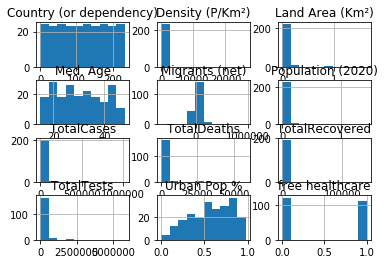

In [14]:
df_raw.hist();

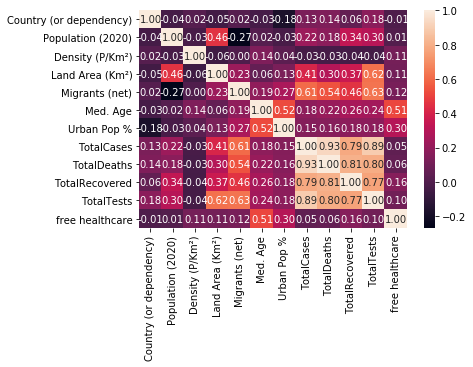

In [15]:
sns.heatmap(df_raw.corr(), annot= True, fmt='.2f');

In [16]:

dic_fh = {1: 'Yes', 0:'No'}


In [17]:
df_c = pd.DataFrame()

In [18]:
df_c['Free Healthcare'] = df_raw['free healthcare']
df_c.replace({'Free Healthcare':dic_fh}, inplace = True)
df_c['Population (2020)'] = df_raw['Population (2020)']
group_dfc2 = df_c.groupby('Free Healthcare').agg({'count','sum'})
df_c['TotalCases'] = df_raw['TotalCases']
df_c['TotalDeaths'] = df_raw['TotalDeaths']
df_c['TotalRecovered'] = df_raw['TotalRecovered']
df_c['TotalTests'] = df_raw['TotalTests']
group_dfc = df_c.groupby('Free Healthcare').sum()
group_dfc['Tests per 1M P']= (group_dfc['TotalTests']*1e6)/group_dfc['Population (2020)']
group_dfc['Cases per 1M P']= (group_dfc['TotalCases']*1e6)/group_dfc['Population (2020)']
group_dfc['Deaths per 100 Cases'] = (group_dfc['TotalDeaths']*100)/group_dfc['TotalCases']
group_dfc['Recovered per 100 Cases'] = (group_dfc['TotalRecovered']*100)/group_dfc['TotalCases']
rate_expected = group_dfc.loc['No','Cases per 1M P']/group_dfc.loc['Yes','Cases per 1M P']


In [19]:
group_dfc.head()

,Population (2020),TotalCases,TotalDeaths,TotalRecovered,TotalTests,Tests per 1M P,Cases per 1M P,Deaths per 100 Cases,Recovered per 100 Cases
Free Healthcare,,,,,,,,,
No,3966933941,1160504.0,63996.0,176703.0,8339874.0,2102.347587,292.544322,5.514501,15.226402
Yes,3827864798,1957646.0,152270.0,769248.0,21617691.0,5647.454166,511.419839,7.778219,39.294540


In [20]:
group_dfc2.head()

Population (2020)            
                            count         sum
Free Healthcare                              
No                            123  3966933941
Yes                           112  3827864798

In [21]:
# set the filepath and load
fp = 'World_Countries.shp'
#reading the file stored in variable fp
map_df = gpd.read_file(fp)
# check data type so we can see that this is not a normal dataframe, but a GEOdataframe
map_df.head()

,COUNTRY,geometry
0,Aruba (Netherlands),"POLYGON ((-69.88223 12.41111, -69.94695 12.436..."
1,Antigua and Barbuda,"MULTIPOLYGON (((-61.73889 17.54055, -61.75195 ..."
2,Afghanistan,"POLYGON ((61.27656 35.60725, 61.29638 35.62853..."
3,Algeria,"POLYGON ((-5.15213 30.18047, -5.13917 30.19236..."
4,Azerbaijan,"MULTIPOLYGON (((46.54037 38.87559, 46.49554 38..."


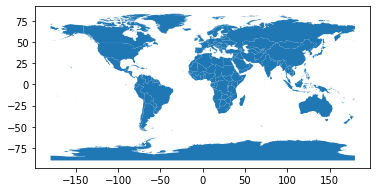

In [22]:
map_df.plot()

In [23]:
df = gpd.read_file(fp)

In [24]:
df.head()

,COUNTRY,geometry
0,Aruba (Netherlands),"POLYGON ((-69.88223 12.41111, -69.94695 12.436..."
1,Antigua and Barbuda,"MULTIPOLYGON (((-61.73889 17.54055, -61.75195 ..."
2,Afghanistan,"POLYGON ((61.27656 35.60725, 61.29638 35.62853..."
3,Algeria,"POLYGON ((-5.15213 30.18047, -5.13917 30.19236..."
4,Azerbaijan,"MULTIPOLYGON (((46.54037 38.87559, 46.49554 38..."


In [ ]:
data_for_map = df.rename(index=str, columns={'COUNTRY': 'COUNTRY', 'geometry': 'geometry'})

In [25]:
df_raw['Country'] = df_raw['Country (or dependency)']
df_raw.replace({'Country': dic_reverse},  inplace = True)


In [26]:
arr_dict = {'Afghanistan':'Afghanistan',
'Albania':'Albania',
'Algeria':'Algeria',
'American Samoa':'American Samoa (US)',
'Andorra':'Andorra',
'Angola':'Angola',
'Anguilla':'Anguilla (UK)',
'Antigua and Barbuda':'Antigua and Barbuda',
'Argentina':'Argentina',
'Armenia':'Armenia',
'Aruba':'Aruba (Netherlands)',
'Australia':'Australia',
'Austria':'Austria',
'Azerbaijan':'Azerbaijan',
'Bahamas':'Bahamas',
'Bahrain':'Bahrain',
'Bangladesh':'Bangladesh',
'Barbados':'Barbados',
'Belarus':'Belarus',
'Belgium':'Belgium',
'Belize':'Belize',
'Benin':'Benin',
'Bermuda':'Bermuda (UK)',
'Bhutan':'Bhutan',
'Bolivia':'Bolivia',
'Bosnia and Herzegovina':'Bosnia and Herzegovina',
'Botswana':'Botswana',
'Brazil':'Brazil',
'British Virgin Islands':'British Virgin Islands(UK)',
'Brunei':'Brunei',
'Bulgaria':'Bulgaria',
'Burkina Faso':'Burkina Faso',
'Burundi':'Burundi',
'Cabo Verde':'Cape Verde',
'Cambodia':'Cambodia',
'Cameroon':'Cameroon',
'Canada':'Canada',
'Caribbean Netherlands':'Netherlands',
'Cayman Islands':'Cayman Islands (UK)',
'Central African Republic':'Central African Republic',
'Chad':'Chad',
'Channel Islands':'Channel Islands',
'Chile':'Chile',
'China':'China',
'Colombia':'Colombia',
'Comoros':'Comoros',
'Congo':'Congo',
'Cook Islands':'Cook Islands (New Zealand)',
'Costa Rica':'Costa Rica',
"Côte d'Ivoire":'Ivory Coast',
'Croatia':'Croatia',
'Cuba':'Cuba',
'Curaçao':'Curacao (Netherlands)',
'Cyprus':'Cyprus',
'Czech Republic (Czechia)':'Czech Republic',
'Denmark':'Denmark',
'Djibouti':'Djibouti',
'Dominica':'Dominica',
'Dominican Republic':'Dominican Republic',
'DR Congo':'Democratic Republic of the Congo',
'Ecuador':'Ecuador',
'Egypt':'Egypt',
'El Salvador':'El Salvador',
'Equatorial Guinea':'Equatorial Guinea',
'Eritrea':'Eritrea',
'Estonia':'Estonia',
'Eswatini':'Swaziland',
'Ethiopia':'Ethiopia',
'Faeroe Islands':'Faroe Islands (Denmark)',
'Falkland Islands':'Falkland Islands (UK)',
'Fiji':'Fiji',
'Finland':'Finland',
'France':'France',
'French Guiana':'French Guiana (France)',
'French Polynesia':'French Polynesia (France)',
'Gabon':'Gabon',
'Gambia':'Gambia',
'Georgia':'Georgia',
'Germany':'Germany',
'Ghana':'Ghana',
'Gibraltar':'Gibraltar (UK)',
'Greece':'Greece',
'Greenland':'Greenland (Denmark)',
'Grenada':'Grenada',
'Guadeloupe':'Guadeloupe (France)',
'Guam':'Guam (US)',
'Guatemala':'Guatemala',
'Guinea':'Guinea',
'Guinea-Bissau':'Guinea-Bissau',
'Guyana':'Guyana',
'Haiti':'Haiti',
'Holy See':'Holy See',
'Honduras':'Honduras',
'Hong Kong':'Hong Kong',
'Hungary':'Hungary',
'Iceland':'Iceland',
'India':'India',
'Indonesia':'Indonesia',
'Iran':'Iran',
'Iraq':'Iraq',
'Ireland':'Ireland',
'Isle of Man':'Isle of Man (UK)',
'Israel':'Israel',
'Italy':'Italy',
'Jamaica':'Jamaica',
'Japan':'Japan',
'Jordan':'Jordan',
'Kazakhstan':'Kazakhstan',
'Kenya':'Kenya',
'Kiribati':'Kiribati',
'Kuwait':'Kuwait',
'Kyrgyzstan':'Kyrgyzstan',
'Laos':'Laos',
'Latvia':'Latvia',
'Lebanon':'Lebanon',
'Lesotho':'Lesotho',
'Liberia':'Liberia',
'Libya':'Libya',
'Liechtenstein':'Liechtenstein',
'Lithuania':'Lithuania',
'Luxembourg':'Luxembourg',
'Macao':'Macao',
'Madagascar':'Madagascar',
'Malawi':'Malawi',
'Malaysia':'Malaysia',
'Maldives':'Maldives',
'Mali':'Mali',
'Malta':'Malta',
'Marshall Islands':'Marshall Islands',
'Martinique':'Martinique (France)',
'Mauritania':'Mauritania',
'Mauritius':'Mauritius',
'Mayotte':'Mayotte (France)',
'Mexico':'Mexico',
'Micronesia':'Federated States of Micronesia',
'Moldova':'Moldova',
'Monaco':'Monaco',
'Mongolia':'Mongolia',
'Montenegro':'Montenegro',
'Montserrat':'Montserrat',
'Morocco':'Morocco',
'Mozambique':'Mozambique',
'Myanmar':'Myanmar',
'Namibia':'Namibia',
'Nauru':'Nauru',
'Nepal':'Nepal',
'Netherlands':'Netherlands',
'New Caledonia':'New Caledonia (France)',
'New Zealand':'New Zealand',
'Nicaragua':'Nicaragua',
'Niger':'Niger',
'Nigeria':'Nigeria',
'Niue':'Niue (New Zealand)',
'North Korea':'North Korea',
'North Macedonia':'Macedonia',
'Northern Mariana Islands':'Northern Mariana Islands (US)',
'Norway':'Norway',
'Oman':'Oman',
'Pakistan':'Pakistan',
'Palau':'Palau (US)',
'Panama':'Panama',
'Papua New Guinea':'Papua New Guinea',
'Paraguay':'Paraguay',
'Peru':'Peru',
'Philippines':'Philippines',
'Poland':'Poland',
'Portugal':'Portugal',
'Puerto Rico':'Puerto Rico (US)',
'Qatar':'Qatar',
'Réunion':'Reunion (France)',
'Romania':'Romania',
'Russia':'Russia',
'Rwanda':'Rwanda',
'Saint Barthelemy':'Saint Barthelemy',
'Saint Helena':'St. Helena (UK)',
'Saint Kitts & Nevis':'St. Kitts and Nevis',
'Saint Lucia':'St. Lucia',
'Saint Martin':'Saint Martin',
'Saint Pierre & Miquelon':'St. Pierre and Miquelon (France)',
'Samoa':'Western Samoa',
'San Marino':'San Marino',
'Sao Tome & Principe':'Sao Tome and Principe',
'Saudi Arabia':'Saudi Arabia',
'Senegal':'Senegal',
'Serbia':'Serbia',
'Seychelles':'Seychelles',
'Sierra Leone':'Sierra Leone',
'Singapore':'Singapore',
'Sint Maarten':'Sint Maarten',
'Slovakia':'Slovakia',
'Slovenia':'Slovenia',
'Solomon Islands':'Solomon Islands',
'Somalia':'Somalia',
'South Africa':'South Africa',
'South Korea':'South Korea',
'South Sudan':'South Sudan',
'Spain':'Spain',
'Sri Lanka':'Sri Lanka',
'St. Vincent & Grenadines':'St. Vincent and the Grenadines',
'State of Palestine':'Palestine',
'Sudan':'Sudan',
'Suriname':'Suriname',
'Sweden':'Sweden',
'Switzerland':'Switzerland',
'Syria':'Syria',
'Taiwan':'Taiwan',
'Tajikistan':'Tajikistan',
'Tanzania':'Tanzania',
'Thailand':'Thailand',
'Timor-Leste':'East Timor',
'Togo':'Togo',
'Tokelau':'Tokelau (New Zealand)',
'Tonga':'Tonga',
'Trinidad and Tobago':'Trinidad and Tobago',
'Tunisia':'Tunisia',
'Turkey':'Turkey',
'Turkmenistan':'Turkmenistan',
'Turks and Caicos':'Turks and Caicos Islands (UK)',
'Tuvalu':'Tuvalu',
'U.S. Virgin Islands':'American Virgin Islands (US)',
'Uganda':'Uganda',
'Ukraine':'Ukraine',
'United Arab Emirates':'United Arab Emirates',
'United Kingdom':'United Kingdom',
'United States':'United States',
'Uruguay':'Uruguay',
'Uzbekistan':'Uzbekistan',
'Vanuatu':'Vanuatu',
'Venezuela':'Venezuela',
'Vietnam':'Vietnam',
'Wallis & Futuna':'Wallis and Futuna (France)',
'Western Sahara':'Western Sahara',
'Yemen':'Yemen',
'Zambia':'Zambia',
'Zimbabwe':'Zimbabwe'}

In [27]:
df_raw.replace({'Country': arr_dict},  inplace = True)

In [28]:
df_raw.head()

,Country (or dependency),Population (2020),Density (P/Km²),Land Area (Km²),Migrants (net),Med. Age,Urban Pop %,TotalCases,TotalDeaths,TotalRecovered,TotalTests,free healthcare,Country
0,43,1439323776,153,9388211,-348399.0,38.0,0.61,82836.0,4633.0,77555.0,NaN,1.0,China
1,96,1380004385,464,2973190,-532687.0,28.0,0.35,31360.0,1008.0,7747.0,716733.0,0.0,India
2,224,331002651,36,9147420,954806.0,38.0,0.83,1027024.0,58341.0,140138.0,5811207.0,0.0,United States
3,97,273523615,151,1811570,-98955.0,30.0,0.56,9511.0,773.0,1254.0,79618.0,0.0,Indonesia
4,158,220892340,287,770880,-233379.0,23.0,0.35,14612.0,312.0,3233.0,157223.0,1.0,Pakistan


In [30]:
dfh = pd.DataFrame()
dfh['Country'] = df_raw['Country']
dfh['free healthcare'] = df_raw['free healthcare']
dfh['TotalCases'] = df_raw['TotalCases']
dfh['TotalCases'].fillna(0, inplace=True)
dfh.isnull().mean()

Country            0.0
free healthcare    0.0
TotalCases         0.0
dtype: float64

In [31]:
merged = map_df.set_index('COUNTRY').join(dfh.set_index('Country'))

In [32]:
merged.head()

,geometry,free healthcare,TotalCases
Afghanistan,"POLYGON ((61.27656 35.60725, 61.29638 35.62853...",0.0,1828.0
Albania,"POLYGON ((20.79192 40.43154, 20.78722 40.39472...",1.0,750.0
Algeria,"POLYGON ((-5.15213 30.18047, -5.13917 30.19236...",1.0,3649.0
American Samoa (US),"POLYGON ((-170.74390 -14.37556, -170.74942 -14...",0.0,0.0
American Virgin Islands (US),"POLYGON ((-64.89612 17.67667, -64.89140 17.683...",0.0,0.0


C:\Users\cvila\Anaconda3\lib\site-packages\matplotlib\colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


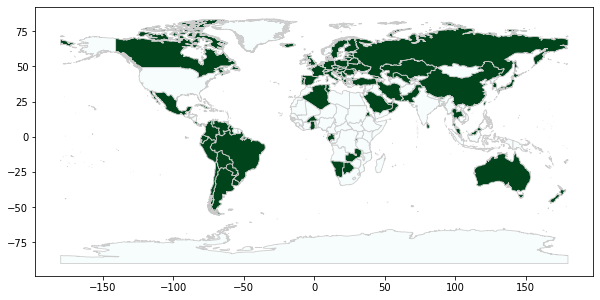

In [36]:
variable = 'free healthcare'# set the range for the choropleth
vmin, vmax = 120, 220# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(10, 6))
merged.plot(column=variable, cmap='BuGn', linewidth=0.8, ax=ax, edgecolor='0.8')